<a href="https://colab.research.google.com/github/Justabhi96/advanced_computer_vision/blob/master/10_Object_Localization_v8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.   Make the pokemon of different sizes also flip the pokemon randomly with arbitrary background
2.   Also make pokemon disppear from some samples
3.   Add different types of pokemon in images




In [1]:
# Install TensorFlow
# !pip install -q tensorflow-gpu==2.0.0

try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.1.0


In [2]:
!wget -nc https://lazyprogrammer.me/course_files/charmander-tight.png
!wget -nc https://lazyprogrammer.me/course_files/bulbasaur-tight.png
!wget -nc https://lazyprogrammer.me/course_files/squirtle-tight.png
!wget -nc https://lazyprogrammer.me/course_files/backgrounds.zip

--2020-02-11 17:55:14--  https://lazyprogrammer.me/course_files/charmander-tight.png
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.31.81.48, 104.31.80.48, 2606:4700:3037::681f:5030, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.31.81.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3952 (3.9K) [image/png]
Saving to: ‘charmander-tight.png’

charmander-tight.pn 100%[===================>]   3.86K  --.-KB/s    in 0s      

2020-02-11 17:55:14 (79.9 MB/s) - ‘charmander-tight.png’ saved [3952/3952]

--2020-02-11 17:55:16--  https://lazyprogrammer.me/course_files/bulbasaur-tight.png
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.31.81.48, 104.31.80.48, 2606:4700:3037::681f:5030, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.31.81.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3435 (3.4K) [image/png]
Saving to: ‘bulbasaur-tight.png’

bulbasaur-tight.png 100%[===================>]   3.35K  --.

In [0]:
!unzip -q backgrounds.zip

In [4]:
import os
os.listdir("backgrounds")

['14.jpg',
 '7.jpg',
 '5.jpg',
 '10.jpg',
 '3.jpg',
 '12.jpg',
 '15.jpg',
 '13.jpg',
 '4.jpg',
 '8.jpg',
 '9.jpg',
 '6.jpg',
 '11.jpg',
 '1.jpg',
 '2.jpg']

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import imageio
from tensorflow.keras.layers import Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy

In [0]:
IMAGE_SIZE = [200, 200, 3]

In [0]:
from glob import glob
backgrounds = []
background_files = glob("backgrounds/*.jpg")
for filename in background_files:
  # they all may not be same size
  bk_img = imageio.imread(filename)
  backgrounds.append(bk_img)

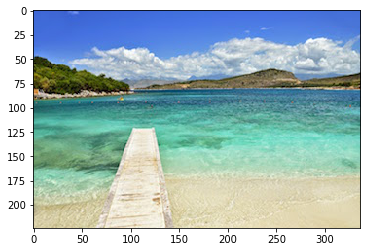

In [8]:
plt.imshow(backgrounds[2])

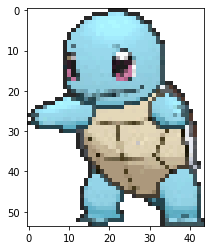

In [10]:
classes = ["Charmander", "Bulabasaur", "Squirtle"]
ch_image = imageio.imread("charmander-tight.png")
ba_image = imageio.imread("bulbasaur-tight.png")
sq_image = imageio.imread("squirtle-tight.png")
ch_h, ch_w, ch_c = ch_image.shape
ba_h, ba_w, ba_c = ba_image.shape
sq_h, sq_w, sq_c = sq_image.shape
poke_data = [[ch_image, ch_h, ch_w, ch_c],
             [ba_image, ba_h, ba_w, ba_c],
             [sq_image, sq_h, sq_w, sq_c]]
plt.imshow(sq_image)

In [0]:
vgg = VGG16(input_shape = IMAGE_SIZE, weights = "imagenet", include_top = False)

x = Flatten()(vgg.output)
x1 = Dense(4, activation = "sigmoid")(x)
x2 = Dense(3, activation = "softmax")(x)
x3 = Dense(1, activation = "sigmoid")(x)

x = Concatenate()([x1, x2, x3])
model = Model(vgg.input, x)

Output of model will be array of 8 values
e.g. [20, 30, 12, 24, 0, 0, 1, 1] i.e [y,x,w,h,class1,class2,class3,object_appeared]
1.    y, x, w, h
2.    one hot encoded class (belongs to squirtle)
3.    whether object is present (True)

In [0]:
from skimage.transform import resize
ref_size = IMAGE_SIZE[0]

def image_generator(batch_size=64):
  # generate image and targets
  while True:
    # Each epoch will have 50 batches. Why? No reason
    for _ in range(50):
      X = np.zeros([batch_size] + IMAGE_SIZE)
      Y = np.zeros([batch_size, 8])

      for i in range(batch_size):
        bg = backgrounds[np.random.choice(len(backgrounds))]
        bg_h, bg_w, _ = bg.shape

        poke_idx = np.random.choice(len(poke_data))
        pk_img, pk_h, pk_w, pk_c = poke_data[poke_idx]

        rand_h = np.random.randint(0, bg_h - ref_size)
        rand_w = np.random.randint(0, bg_w - ref_size)

        X[i] = bg[rand_h: rand_h+ref_size, rand_w: rand_w+ref_size].copy()

        appear = np.random.random() < 0.75
        if appear:
          # to make charmander bigger or smaller
          scale = 0.5 + np.random.random() #[0.5, 1.5]
          new_h = int(pk_h * scale)
          new_w = int(pk_w * scale)

          new_ch_img = resize(pk_img, (new_h, new_w), 
                              preserve_range=True).astype(np.uint8) # to keep the range 0 - 255
          if np.random.random() < 0.5:
            new_ch_img = np.fliplr(new_ch_img)

          row0 = np.random.randint(0, ref_size - new_h)
          col0 = np.random.randint(0, ref_size - new_w)
          row1 = row0 + new_h
          col1 = col0 + new_w

          # to paste charmander in background without removing background
          mask = (new_ch_img[:,:,3] == 0) # find where pokemon is zero
          bg_slice = X[i, row0:row1, col0:col1, :] # where we want to place the pokemon
          bg_slice = np.expand_dims(mask, -1) * bg_slice # (h,w,1)*(h,w,3)
          bg_slice += new_ch_img[:,:,:3] # add the pokemon to the slice
          X[i, row0:row1, col0:col1, :] = bg_slice # put the slice back

          Y[i, 0] = row0/ref_size
          Y[i, 1] = col0/ref_size
          Y[i, 2] = (col1-col0)/ref_size
          Y[i, 3] = (row1-row0)/ref_size

          # for one hot encoding the belonging class
          Y[i, 4+poke_idx] = 1

        # whether pokemon appear or not
        Y[i, 7] = appear

      yield X/255.0, Y

[0.055 0.19  0.275 0.31  0.    1.    0.    1.   ]


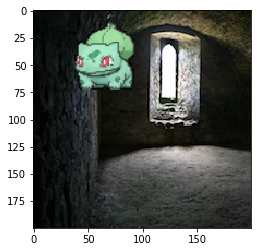

In [24]:
xx = None
yy = None
for x, y in image_generator():
  xx, yy = x, y
  break
print(yy[10])
plt.imshow(xx[10])

In [0]:
def cust_loss(ytrue, ypred):
  # target is 5 values 
  bce = binary_crossentropy(ytrue[:, :-1], ypred[:, :-1]) # loss for coords
  # loss for binary classification(object present or not)
  bce2 = binary_crossentropy(ytrue[:, -1], ypred[:, -1])
  cce = categorical_crossentropy(ytrue[:, 4:7], ypred[:, 4:7]) # object class

  return bce * ytrue[:, -1] + cce * ytrue[:, -1] + 0.5 * bce2

In [26]:
model.compile(optimizer=Adam(lr = 0.0001), loss = cust_loss)
model.fit_generator(image_generator(), epochs = 5, steps_per_epoch=50)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 50 steps
Epoch 1/5
50/50 [==============================] - 53s 1s/step - loss: 0.7414
Epoch 2/5
50/50 [==============================] - 36s 723ms/step - loss: 0.2454
Epoch 3/5
50/50 [==============================] - 36s 729ms/step - loss: 0.2329
Epoch 4/5
50/50 [==============================] - 37s 736ms/step - loss: 0.2307
Epoch 5/5
50/50 [==============================] - 37s 739ms/step - loss: 0.2303


In [0]:
from matplotlib.patches import Rectangle

def make_prediction():
  bg = backgrounds[np.random.choice(len(backgrounds))]
  bg_h, bg_w, _ = bg.shape

  rand_h = np.random.randint(0, bg_h - ref_size)
  rand_w = np.random.randint(0, bg_w - ref_size)

  poke_idx = np.random.choice(len(poke_data))
  pk_img, pk_h, pk_w, pk_c = poke_data[poke_idx]
  
  x = bg[rand_h: rand_h+ref_size, rand_w: rand_w+ref_size].copy()

  appear = np.random.random() < 0.75
  if appear:
    # to make charmander bigger or smaller
    scale = 0.5 + np.random.random() #[0.5, 1.5]
    new_h = int(pk_h * scale)
    new_w = int(pk_w * scale)

    new_ch_img = resize(pk_img, (new_h, new_w), 
                        preserve_range=True).astype(np.uint8)
    if np.random.random() < 0.5:
      new_ch_img = np.fliplr(new_ch_img)

    row0 = np.random.randint(0, ref_size - new_h)
    col0 = np.random.randint(0, ref_size - new_w)
    row1 = row0 + new_h
    col1 = col0 + new_w

    # to paste charmander in background without removing background
    mask = (new_ch_img[:,:,3] == 0) # find where pokemon is zero
    bg_slice = x[row0:row1, col0:col1, :] # where we want to place the pokemon
    bg_slice = np.expand_dims(mask, -1) * bg_slice # (h,w,1)*(h,w,3)
    bg_slice += new_ch_img[:,:,:3] # add the pokemon to the slice
    x[row0:row1, col0:col1, :] = bg_slice # put the slice back

  X = np.expand_dims(x, 0)
  p = model.predict(X/255.0)[0]
  fig, ax = plt.subplots(1)
  ax.imshow(x.astype(np.uint8))
  if p[-1] <= 0.5:
    print("No object")
  else:
    print(classes[np.argmax(p[4:7])])
    y, x, w, h = p[0]*ref_size, p[1]*ref_size, p[2]*ref_size, p[3]*ref_size
    rect = Rectangle((x, y), w, h, linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
  plt.show()

No object


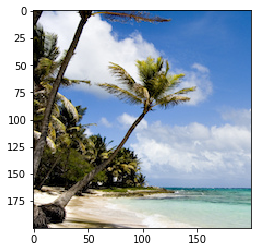

In [38]:
make_prediction()

Squirtle


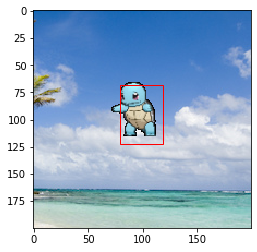

In [34]:
make_prediction()